Optimizing RFR Models based on Perovskite Compositions
======================================================

**Author:** Panayotis Manganaris



## Dependencies



In [38]:
# featurization
import cmcl
from cmcl import Categories
# multi-criterion model evaluation
from yogi.model_selection import summarize_HPO
from yogi.model_selection import pandas_validation_curve as pvc
from yogi.metrics.pandas_scoring import PandasScoreAdaptor as PSA
from yogi.metrics.pandas_scoring import batch_score
# visualization convenience
from spyglass.model_imaging import parityplot

The Intel distribution provides accelerated ml algorithms. Run this cell before importing the algorithms. "cmcl" and "yogi" are our in-house modules for analyzing chemical compositions and enabling different nuts and bolts of ML algorithms.



In [39]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [40]:
# data tools
import sqlite3
import pandas as pd
import numpy as np
# feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, Normalizer, StandardScaler
# predictors
from sklearn.ensemble import RandomForestRegressor
## pipeline workflow
from sklearn.pipeline import make_pipeline as mkpipe
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV as gsCV
# model eval
from sklearn.base import clone
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, explained_variance_score, max_error
import joblib
#visualization
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
# ignore all FutureWarnings -- handling coming in a future version of yogi
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Load Data and Compute Composition Vectors



### Load Curated Subset of Mannodi Data



In [41]:
my = pd.read_csv("./mannodi_data.csv").set_index(["index", "Formula", "sim_cell"])
lookup = pd.read_csv("./constituent_properties.csv").set_index("Formula")

### Compute Compostion Vectors using cmcl



Additionally, cmcl offers a convenience function for creating groups out of the column labels (groups = type of mixing in this dataset).



In [42]:
mc = my.ft.comp() # compute numerical compostion vectors from strings
mc = mc.collect.abx() # convenient site groupings for perovskites data

### Generate mix category and assign to index for future imaging



Helps with visualizing the final model performance by tracking the features through all the model development transformations.



In [43]:
mixlog = mc.groupby(level=0, axis=1).count()
mix = mixlog.pipe(Categories.logif, condition=lambda x: x>1, default="pure", catstring="and")
mc = mc.assign(mix=mix).set_index("mix", append=True)
my = my.assign(mix=mix).set_index("mix", append=True)

## Model BG Using Composition Vectors



### Make Composition Pipeline



The model we use relies on a standard chain of data preprocessing steps. These steps are encapsulated in a single meta-estimator called a "pipeline." The pipeline is instantiated with a set of default "hyperparameters."

Later, a hyperparameter optimization strategy based on exhaustive grid search will chose parameters that ensure the architecture performs as best it can for general high-accuracy prediction.



In [44]:
fillna = SimpleImputer(strategy="constant", fill_value=0.0)
cpipe = mkpipe(fillna, Normalizer(), RandomForestRegressor())

### Scoring Scheme



The composition space is approximated by a set of discrete domains due the limited nature of the 2x2x2 supercells used to obtain this data. The pure domain is completely covered by 90 data points. The alloy domains are combinatorially large in the 14 dimensional component space under focus, and each has only been sparsely sampled.

Our primary objective is to create a surrogate model of these domains that can be used for on-demand prediction, active learning, and inverse design.

In order to target model generality, it will be necessary to score the model's performance with respect to it's predictions individually over each alloy domain and over the union of these domains.



#### Prepare subset scoring weights and ordinal group labels



In [45]:
mixweight = pd.get_dummies(mix)
mixcat = pd.Series(OrdinalEncoder().fit_transform(mix.values.reshape(-1, 1)).reshape(-1),
                     index=mc.index).astype(int)

#### Define Scoring Metrics


Nine metrics are used to monitor the fitness of the random forest model. Some monitor the data trend and spread:

-   R<sup>2</sup>
-   Explained Variance


One monitors the largest breakdown in accuracy:

-   Max Error


The remaining six group-wise RMSE metrics monitor the accuracy for each type of data point:

-   total RMSE
-   A-site RMSE
-   B-site RMSE
-   X-site RMSE
-   XandB-site RMSE
-   pure RMSE


The PandasScoreAdaptor (PSA) ensures the prediction losses are weighted correctly when scoring as long as both the targets and the sample weights passed to the estimators are always pandas objects.



In [46]:
site_mse = PSA(mean_squared_error).score
scorings = {'r2': make_scorer(r2_score),
            'ev': make_scorer(explained_variance_score),
            'maxerr': make_scorer(max_error, greater_is_better=False),
            'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
            'A_rmse': make_scorer(site_mse, greater_is_better=False,
                                  squared=False, sample_weight=mixweight.A),
            'B_rmse': make_scorer(site_mse, greater_is_better=False,
                                  squared=False, sample_weight=mixweight.B),
            'X_rmse': make_scorer(site_mse, greater_is_better=False,
                                  squared=False, sample_weight=mixweight.X),
            'BandX_rmse': make_scorer(site_mse, greater_is_better=False,
                                      squared=False, sample_weight=mixweight.BandX),
            'Pure_rmse': make_scorer(site_mse, greater_is_better=False,
                                     squared=False, sample_weight=mixweight.pure),}

### Make Dedicated Test Train Split



A dedicated test-train split is made. This split preserves the proportion of each alloy group in the test and train partitions, which helps with the final model evaluation. 

-   All decisions about model optimization will be made using only the dedicated training partition.
-   The test partition will be reserved until a final model pipeline is parametrized and fit.
-   The predictions made on the test partition will either confirm or deny the model's ability to work outside of the training domain.



In [47]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=None)
train_idx, test_idx = next(sss.split(mc, mixcat)) #stratify split by mix categories
mc_tr, mc_ts = mc.iloc[train_idx], mc.iloc[test_idx]
my_tr, my_ts = my.iloc[train_idx], my.iloc[test_idx]
mixcat_tr, mixcat_ts = mixcat.iloc[train_idx], mixcat.iloc[test_idx]

### Learning Curves &#x2013; Using Deterministically Random Cross Validation



Cross-validation within the training set will be the only way of checking the generality of models, aside from predictions on the test set. The first step is to obtain an understanding of how much data is needed for training that can be suitably generalized.

10-fold cross-validation yields 10 sample scores at each partition size. This means 90% of the training set is used for actual training and the remaining 10% is used for validation.

The shuffling is seeded with a deterministic random state to ensure scores are comparable across partition size



In [48]:
kf_lc = KFold(n_splits=10, shuffle=True, random_state=111)

In [49]:
with joblib.parallel_backend('multiprocessing'):
  LC = pvc(learning_curve, cpipe, mc_tr, my_tr.PBE_bg_eV,
           train_sizes=np.linspace(0.1, 1.0, 10), cv=kf_lc, scoring=scorings)
  LC = LC.melt(id_vars=["partition"], ignore_index=False).reset_index()

[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18

[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:53:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on 

[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:07 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU


[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:08 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:10 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 18:54:11 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

Notice that the error metrics are negated so that, consistently with
the R<sup>2</sup> and ev scores, the greater the number, the better the model
performs.



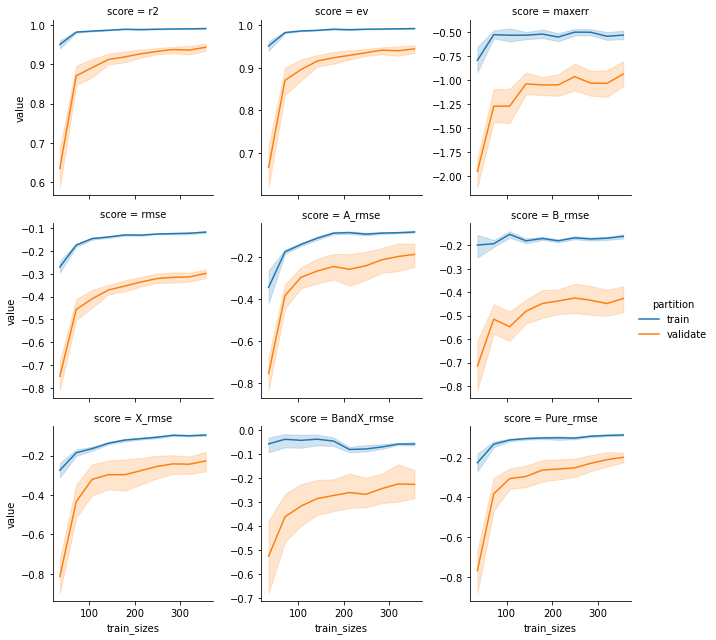

In [50]:
p = sns.FacetGrid(LC, col="score", hue="partition", col_wrap=3, sharey=False)
p.map(sns.lineplot, "train_sizes", "value")
p.add_legend()
p.figure.show()

The Random Forest's validation scores continue to rise as the partition size grows

-   Random Forest generality increases with more exposure
-   Equivalently, an insufficiently experienced random forest is biased towards what it has seen.


### Obtain Generality Baseline



The four main alloy classes are roughly equally represented in the dataset. It would be interesting to see if a model trained on only three of them performs well on the fourth.

There are four main groups, so we use four groupwise partitions. The tiny "BandX" group is mixed in with the others. The splitter uses the mixcat ordinal series to ensure the index splits are correct. --> PANOS, remove the B-and-X thing.



In [52]:
gkf = GroupKFold(n_splits=4)

A function is defined to streamline this test and ensure it cannot contaminate the estimator to be optimized.



In [53]:
def test_generality(estimator, X_tr, y_tr, groups_tr, X_ts, y_ts, groups_ts):
    estimator = clone(estimator) #unfitted, cloned params
    gentpl = gkf.split(X_tr, y_tr, groups=groups_tr), gkf.split(X_ts, y_ts, groups=groups_ts)
    #train and test index generators, in order
    val_scores = []
    tst_scores = []
    for train_idx, val_idx, _, tst_idx in [sum(gengroup, ()) for gengroup in zip(*gentpl)]:
        tr_val_group_names = groups_tr.iloc[val_idx].index.get_level_values("mix").unique()
        ts_group_names = groups_ts.iloc[tst_idx].index.get_level_values("mix").unique()
        #fit to tr part
        estimator.fit(X_tr.iloc[train_idx], y_tr.iloc[train_idx])
        #get val and test scores
        tr_val_score_series = pd.Series(batch_score(estimator, X_tr.iloc[val_idx], y_tr.iloc[val_idx], **scorings))
        tr_val_score_series.name="_&_".join(tr_val_group_names)
        ts_score_series = pd.Series(batch_score(estimator, X_ts.iloc[tst_idx], y_ts.iloc[tst_idx], **scorings))
        ts_score_series.name="_&_".join(ts_group_names)
        val_scores.append(tr_val_score_series)
        tst_scores.append(ts_score_series)
    tr_val_scores = pd.concat(val_scores, axis=1).assign(partition="validation")
    ts_scores = pd.concat(tst_scores, axis=1).assign(partition="test")
    group_scores = pd.concat([tr_val_scores, ts_scores]).round(5).drop_duplicates(keep="first")
    return group_scores

In [16]:
test_generality(cpipe, mc_tr, my_tr.PBE_bg_eV, mixcat_tr, mc_ts, my_ts.PBE_bg_eV, mixcat_ts)

[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:30:15 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


,B,X,A,pure_&_BandX,partition
r2,0.15599,0.92169,0.92782,0.97394,validation
ev,0.46325,0.93108,0.94769,0.97434,validation
maxerr,-2.38936,-1.31068,-1.22644,-0.64545,validation
rmse,-0.88007,-0.37202,-0.37999,-0.23724,validation
BandX_rmse,-0.88007,-0.37202,-0.37999,-0.12330,validation
Pure_rmse,-0.88007,-0.37202,-0.37999,-0.24201,validation
r2,0.57526,0.87956,0.87756,0.96627,test
ev,0.69547,0.90473,0.93078,0.96667,test
maxerr,-2.15078,-1.26922,-1.01706,-0.53324,test
rmse,-0.67546,-0.47401,-0.44342,-0.25339,test


-   There are substantial errors in all the groups
    -   in the test partition, the model utterly fails in extrapolating the bandgaps of B-mixed alloys
    -   in the train partition, it's still not good
    -   however, extrapolating the other partitions is relatively much better
-   The B partition is mostly representative of the others
    -   w.r.t the underlying function as identified by this specific model architecture
    -   different architectures can be inclined to learn different characteristics of a function

**Note:** batch<sub>score</sub> defaults to unweighted scoring if the sum of weights
in the given sample equal zero, that is why most of the group-wise rmse
scores are the same.



### Optimize Hyper-parameters for Composition Model



#### Define first level of Hyperparameter search



These cells archive the optimization process, running them is not necessary. The result is saved in the notebook at the end.



##### Construct original Hyper-parameter Space



In [1]:
grid = [
    {'normalizer__norm': ['l1', 'l2', 'max'],
     'randomforestregressor__bootstrap': [True], #build each tree from sample
     'randomforestregressor__ccp_alpha': [0.0, 0.002], #cost-complexity pruning
     'randomforestregressor__criterion': ['squared_error', 'absolute_error', 'poisson'], #variance reductions vs deviance reduction
     #'randomforestregressor__maxBins:': [256],
     'randomforestregressor__max_depth': [25, 20], #investigate dept of constituent trees, limit
     'randomforestregressor__max_features': ['auto', 3, 5], #split after considering
     'randomforestregressor__max_leaf_nodes': [750, 800], #see depth exploration in DT notes
     'randomforestregressor__max_samples': [0.9, 0.6, 0.3], #frac to bag
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0, 0.3], #0.3 corresponds to the onset of aggressive ccp
     'randomforestregressor__min_samples_leaf': [1], #just sensible
     'randomforestregressor__min_samples_split': [2, 5], #
     'randomforestregressor__min_weight_fraction_leaf': [0.0], #
     'randomforestregressor__n_estimators': [20, 50, 100],
     'randomforestregressor__n_jobs': [4], #parallelize exec
     'randomforestregressor__oob_score': [True], #use out-of-bag samples to validate (faster)
     'randomforestregressor__random_state': [None], #do not touch
     'randomforestregressor__verbose': [0], 
     'randomforestregressor__warm_start': [False] #make a new forest every time (honest)
     },
    {'normalizer__norm': ['l1', 'l2', 'max'],
     'randomforestregressor__bootstrap': [False], #Build each tree from everything
     'randomforestregressor__ccp_alpha': [0.0, 0.002], #cost-complexity pruning
     'randomforestregressor__criterion': ['squared_error', 'absolute_error', 'poisson'], #variance reductions vs deviance reduction
     #'randomforestregressor__maxBins:': [256],
     'randomforestregressor__max_depth': [25, 20], #investigate dept of constituent trees, limit
     'randomforestregressor__max_features': ['auto', 3, 5], #split after considering
     'randomforestregressor__max_leaf_nodes': [750, 800], #see depth exploration in DT notes
     'randomforestregressor__max_samples': [None], #"bag" everything
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0, 0.3], #
     'randomforestregressor__min_samples_leaf': [1], #just sensible
     'randomforestregressor__min_samples_split': [2, 5], #
     'randomforestregressor__min_weight_fraction_leaf': [0.0], #
     'randomforestregressor__n_estimators': [20, 50, 100],
     'randomforestregressor__n_jobs': [4], #parallelize exec
     #oob score not available
     'randomforestregressor__random_state': [None], #do not touch
     'randomforestregressor__verbose': [0], 
     'randomforestregressor__warm_start': [False] #make a new forest every time (honest)
     }
]

##### Composition model of PBE<sub>BG</sub>



initially, only 3 fold validation is used to save on computation time



In [1]:
cgs = gsCV(estimator=cpipe,
            param_grid=grid,
            cv=3, verbose=1, scoring=scorings, refit="r2", return_train_score=True)

with joblib.parallel_backend('multiprocessing'):
    cgs.fit(mc_tr, my_tr.PBE_bg_eV)

Fitting 3 folds for each of 10368 candidates, totalling 31104 fits &#x2013; about 45 minutes to fit with acceleration.



##### Determine next Grid Space to explore

The cell below provides a HP search grid and applies weights of importance to each of the 9 error metrics (B_rmse is given a weight "2" to improve B-site mixed predictions further).

In [1]:
summary, next_grid = summarize_HPO(cgs, grid, topN=10, metric_weights=[1,1,1,1,1,2,1,0,1], strategy="oavg")
summary

Mostly Equal Weights In Summary:

| |space<sub>0</sub>|space<sub>1</sub>|entropy<sub>0</sub>|entropy<sub>1</sub>|scores<sub>0</sub>|scores<sub>1</sub>|next<sub>0</sub>|next<sub>1</sub>|
|---|---|---|---|---|---|---|---|---|
| normalizer_<sub>norm</sub>|[l1, l2, max]|[l1, l2, max]|0.853155|0.853155|[19.07, 0.07, 10.74]|[19.07, 0.07, 10.74]|[l1, max]|[l1, max]|
| bootstrap|[True]|[False]|0.142457|0.289120|[26.18]|[3.69]|[True]|[False]|
| ccp<sub>alpha</sub>|[0.0, 0.002]|[0.0, 0.002]|0.485723|0.485723|[27.33, 2.54]|[27.33, 2.54]|[0.0]|[0.0]|
| criterion|[squared<sub>error</sub>, absolute<sub>error</sub>, poisson]|[squared<sub>error</sub>, absolute<sub>error</sub>, poisson]|0.687787|0.687787|[18.12, 11.75, 0.0]|[18.12, 11.75, 0.0]|[squared<sub>error</sub>, absolute<sub>error</sub>]|[squared<sub>error</sub>, absolute<sub>error</sub>]|
| max<sub>depth</sub>|[25, 20]|[25, 20]|0.683604|0.683604|[14.16, 15.72]|[14.16, 15.72]|[20]|[20]|
| max<sub>features</sub>|[auto, 3, 5]|[auto, 3, 5]|0.759206|0.759206|[25.04, 0.06, 4.78]|[25.04, 0.06, 4.78]|[auto]|[auto]|
| max<sub>leaf</sub><sub>nodes</sub>|[750, 800]|[750, 800]|0.692553|0.692553|[14.88, 15.0]|[14.88, 15.0]|[800]|[800]|
| max<sub>samples</sub>|[0.9, 0.6, 0.3]|[None]|0.812818|0.289120|[21.28, 4.82, 0.09]|[0.16]|[0.9]|[None]|
| minBinSize|[1]|[1]|-0.000000|-0.000000|NaN|NaN|[1]|[1]|
| min<sub>impurity</sub><sub>decrease</sub>|[0.0, 0.3]|[0.0, 0.3]|-0.000000|-0.000000|NaN|NaN|[0.0]|[0.0]|
| min<sub>samples</sub><sub>leaf</sub>|[1]|[1]|-0.000000|-0.000000|NaN|NaN|[1]|[1]|
| min<sub>samples</sub><sub>split</sub>|[2, 5]|[2, 5]|0.485723|0.485723|[26.1, 3.77]|[26.1, 3.77]|[2]|[2]|
| min<sub>weight</sub><sub>fraction</sub><sub>leaf</sub>|[0.0]|[0.0]|-0.000000|-0.000000|NaN|NaN|[0.0]|[0.0]|
| n<sub>estimators</sub>|[20, 50, 100]|[20, 50, 100]|1.083522|1.083522|[7.95, 8.22, 13.7]|[7.95, 8.22, 13.7]|[100]|[100]|
| n<sub>jobs</sub>|[4]|[4]|-0.000000|-0.000000|NaN|NaN|[4]|[4]|
| oob<sub>score</sub>|[True]|NaN|0.142457|NaN|[0.84]|NaN|[True]|NaN|
| random<sub>state</sub>|[None]|[None]|-0.000000|-0.000000|NaN|NaN|[None]|[None]|
| verbose|[0]|[0]|-0.000000|-0.000000|NaN|NaN|[0]|[0]|
| warm<sub>start</sub>|[False]|[False]|-0.000000|-0.000000|NaN|NaN|[False]|[False]|

-   l1 normalization is best
-   bootstrapping the regressor is much more performant
    -   90% sampling is best (rfr improves with more exposure, makes sense)
    -   notice: bootstrap sampling appears to rank only slightly more
        frequently in the top ten than no-bootstrap, but has much higher
        scores. suggesting it also dominates the highest ranks in general.
-   max normalization also does well, but not as well
-   squared error does best
-   absolute<sub>error</sub> (more expensive) is less susceptible to compromising on extremes, but appears mostly unfavorable
-   limiting tree depth slightly better than not limiting it
-   growth on all features better than growth on few features. larger axis limits yet to be explored
-   unlimited nodes marginally better than limited nodes
-   impurity decrease threshold is ineffective
-   unlimited split granularity better than limited granularity
-   generally, more estimators outperform fewer

Favorably Weighting B scores:

| |space<sub>0</sub>|space<sub>1</sub>|entropy<sub>0</sub>|entropy<sub>1</sub>|scores<sub>0</sub>|scores<sub>1</sub>|next<sub>0</sub>|next<sub>1</sub>|
|---|---|---|---|---|---|---|---|---|
| normalizer_<sub>norm</sub>|[l1, l2, max]|[l1, l2, max]|0.853155|0.853155|[21.94, 0.07, 11.25]|[21.94, 0.07, 11.25]|[l1, max]|[l1, max]|
| bootstrap|[True]|[False]|0.142457|0.289120|[29.47]|[3.79]|[True]|[False]|
| ccp<sub>alpha</sub>|[0.0, 0.002]|[0.0, 0.002]|0.485723|0.485723|[30.68, 2.58]|[30.68, 2.58]|[0.0]|[0.0]|
| criterion|[squared<sub>error</sub>, absolute<sub>error</sub>, poisson]|[squared<sub>error</sub>, absolute<sub>error</sub>, poisson]|0.687787|0.687787|[21.39, 11.87, 0.0]|[21.39, 11.87, 0.0]|[squared<sub>error</sub>, absolute<sub>error</sub>]|[squared<sub>error</sub>, absolute<sub>error</sub>]|
| max<sub>depth</sub>|[25, 20]|[25, 20]|0.683604|0.683604|[16.54, 16.72]|[16.54, 16.72]|[20]|[20]|
| max<sub>features</sub>|[auto, 3, 5]|[auto, 3, 5]|0.759206|0.759206|[27.43, 0.06, 5.77]|[27.43, 0.06, 5.77]|[auto]|[auto]|
| max<sub>leaf</sub><sub>nodes</sub>|[750, 800]|[750, 800]|0.692553|0.692553|[17.34, 15.92]|[17.34, 15.92]|[750]|[750]|
| max<sub>samples</sub>|[0.9, 0.6, 0.3]|[None]|0.812818|0.289120|[22.68, 6.69, 0.09]|[0.16]|[0.9]|[None]|
| minBinSize|[1]|[1]|-0.000000|-0.000000|NaN|NaN|[1]|[1]|
| min<sub>impurity</sub><sub>decrease</sub>|[0.0, 0.3]|[0.0, 0.3]|-0.000000|-0.000000|NaN|NaN|[0.0]|[0.0]|
| min<sub>samples</sub><sub>leaf</sub>|[1]|[1]|-0.000000|-0.000000|NaN|NaN|[1]|[1]|
| min<sub>samples</sub><sub>split</sub>|[2, 5]|[2, 5]|0.485723|0.485723|[28.39, 4.87]|[28.39, 4.87]|[2]|[2]|
| min<sub>weight</sub><sub>fraction</sub><sub>leaf</sub>|[0.0]|[0.0]|-0.000000|-0.000000|NaN|NaN|[0.0]|[0.0]|
| n<sub>estimators</sub>|[20, 50, 100]|[20, 50, 100]|1.083522|1.083522|[9.59, 8.5, 15.18]|[9.59, 8.5, 15.18]|[100]|[100]|
| n<sub>jobs</sub>|[4]|[4]|-0.000000|-0.000000|NaN|NaN|[4]|[4]|
| oob<sub>score</sub>|[True]|NaN|0.142457|NaN|[0.84]|NaN|[True]|NaN|
| random<sub>state</sub>|[None]|[None]|-0.000000|-0.000000|NaN|NaN|[None]|[None]|
| verbose|[0]|[0]|-0.000000|-0.000000|NaN|NaN|[0]|[0]|
| warm<sub>start</sub>|[False]|[False]|-0.000000|-0.000000|NaN|NaN|[False]|[False]|

-   gap between limited and unlimited tree depth closes slightly
-   limited leaf nodes becomes more favorable than unlimited leaf nodes &#x2013; reversal!
-   20 estimators actually ranks much higher. less averaging => more bias helps B



#### &#x2013; Iteratively Optimize Hyperparameters



##### Construct subsequent HP space



next_grid helps set up the next exhaustive search

-   l1 normalization is chosen
-   bootstrapping is chosen
-   squared and absolute error compete again
-   depth limits are broadened &#x2013; explore strong limits and no limits
-   larger feature access limits are tried
-   strong limits on leaf notes are tried along with no limits and moderate limits
-   recommendations taken for others



In [1]:
grid = [
    {'normalizer__norm': ['l1'],
     'randomforestregressor__bootstrap': [True],
     'randomforestregressor__ccp_alpha': [0.0],
     'randomforestregressor__criterion': ['squared_error', 'absolute_error'],
     'randomforestregressor__max_depth': [15, 20, None], #broadening search
     'randomforestregressor__max_features': ['auto', 10], #larger limit
     'randomforestregressor__max_leaf_nodes': [700, 800, None], #broadening search
     'randomforestregressor__max_samples': [0.9], #gives bootstrapping it's best chance
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0],
     'randomforestregressor__min_samples_leaf': [1],
     'randomforestregressor__min_samples_split': [2],
     'randomforestregressor__min_weight_fraction_leaf': [0.0],
     'randomforestregressor__n_estimators': [50, 100, 150], #broadening search
     'randomforestregressor__n_jobs': [4],
     'randomforestregressor__oob_score': [True],
     'randomforestregressor__random_state': [None],
     'randomforestregressor__verbose': [0],
     'randomforestregressor__warm_start': [False]},
]

##### Composition model of PBE<sub>BG</sub>



In [1]:
cgs = gsCV(estimator=cpipe,
            param_grid=grid,
            cv=3, verbose=1, scoring=scorings, refit="r2", return_train_score=True)

with joblib.parallel_backend('multiprocessing'):
    cgs.fit(mc_tr, my_tr.PBE_bg_eV)

Fitting 3 folds for each of 108 candidates, totalling 324 fits &#x2013; just a few minutes



##### Determine next Grid Space to explore



In [1]:
summary, next_grid = summarize_HPO(cgs, grid, topN=10, metric_weights=[1,1,1,1,1,2,1,0,1], strategy="oavg")
summary

Mostly Equal Weights In Summary:

| |space<sub>0</sub>|entropy<sub>0</sub>|scores<sub>0</sub>|next<sub>0</sub>|
|---|---|---|---|---|
| normalizer_<sub>norm</sub>|[l1]|-0.000000|NaN|[l1]|
| bootstrap|[True]|-0.000000|NaN|[True]|
| ccp<sub>alpha</sub>|[0.0]|-0.000000|NaN|[0.0]|
| criterion|[squared<sub>error</sub>, absolute<sub>error</sub>]|0.673012|[26.46, 9.32]|[squared<sub>error</sub>]|
| max<sub>depth</sub>|[15, 20, None]|1.092669|[11.65, 10.56, 0.33]|[15, 20]|
| max<sub>features</sub>|[auto, 10]|0.650818|[21.97, 13.81]|[auto]|
| max<sub>leaf</sub><sub>nodes</sub>|[700, 800, None]|1.092669|[9.65, 8.09, 0.38]|[700, 800]|
| max<sub>samples</sub>|[0.9]|-0.000000|NaN|[0.9]|
| minBinSize|[1]|-0.000000|NaN|[1]|
| min<sub>impurity</sub><sub>decrease</sub>|[0.0]|-0.000000|NaN|[0.0]|
| min<sub>samples</sub><sub>leaf</sub>|[1]|-0.000000|NaN|[1]|
| min<sub>samples</sub><sub>split</sub>|[2]|-0.000000|NaN|[2]|
| min<sub>weight</sub><sub>fraction</sub><sub>leaf</sub>|[0.0]|-0.000000|NaN|[0.0]|
| n<sub>estimators</sub>|[50, 100, 150]|1.094257|[8.31, 13.14, 14.32]|[100, 150]|
| n<sub>jobs</sub>|[4]|-0.000000|NaN|[4]|
| oob<sub>score</sub>|[True]|-0.000000|NaN|[True]|
| random<sub>state</sub>|[None]|-0.000000|NaN|[None]|
| verbose|[0]|-0.000000|NaN|[0]|
| warm<sub>start</sub>|[False]|-0.000000|NaN|[False]|

-   squared error still better than absolute error, but absolute error is still fairly common
-   strong limits on depth perform better than unlimited depth &#x2013; limits tree bias
-   unlimited feature access still better than fewer
-   limited nodes actually outperforms unlimited. more aggressive limits are better
-   150 estimators outperforms 100 &#x2013; sensitivity is likely

more heavily weighting B scores make no change to interpretation



#### &#x2013; Iteratively Optimize Hyperparameters



##### Construct subsequent HP space



In the limited tree domains, without interference from n<sub>estimators</sub>, various criterion are explored in detail.



In [1]:
grid = [
    {'normalizer__norm': ['l1'],
     'randomforestregressor__bootstrap': [True],
     'randomforestregressor__ccp_alpha': [0.0],
     'randomforestregressor__criterion': ['squared_error', 'absolute_error', 'poisson'],
     'randomforestregressor__max_depth': [15, 20],
     'randomforestregressor__max_features': ['auto'],
     'randomforestregressor__max_leaf_nodes': [600, 700, 800],
     'randomforestregressor__max_samples': [0.9],
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0],
     'randomforestregressor__min_samples_leaf': [1],
     'randomforestregressor__min_samples_split': [2],
     'randomforestregressor__min_weight_fraction_leaf': [0.0],
     'randomforestregressor__n_estimators': [100], #compromise in anticipation of possible overfitting
     'randomforestregressor__n_jobs': [4],
     'randomforestregressor__oob_score': [True],
     'randomforestregressor__random_state': [None],
     'randomforestregressor__verbose': [0],
     'randomforestregressor__warm_start': [False]
     }
]

##### Composition model of PBE<sub>BG</sub>



In [1]:
cgs = gsCV(estimator=cpipe,
            param_grid=grid,
            cv=3, verbose=1, scoring=scorings, refit="r2", return_train_score=True)

with joblib.parallel_backend('multiprocessing'):
    cgs.fit(mc_tr, my_tr.PBE_bg_eV)

Fitting 3 folds for each of 18 candidates, totalling 54 fits



##### Determine next Grid Space to explore



In [1]:
summary, next_grid = summarize_HPO(cgs, grid, topN=10, metric_weights=[1,1,1,1,1,2,1,0,1], strategy="oavg")
summary

In Summary:

| |space<sub>0</sub>|entropy<sub>0</sub>|scores<sub>0</sub>|next<sub>0</sub>|
|---|---|---|---|---|
| normalizer_<sub>norm</sub>|[l1]|-0.000000|NaN|[l1]|
| bootstrap|[True]|-0.000000|NaN|[True]|
| ccp<sub>alpha</sub>|[0.0]|-0.000000|NaN|[0.0]|
| criterion|[squared<sub>error</sub>, absolute<sub>error</sub>, poisson]|1.054920|[18.27, 14.65, 2.16]|[squared<sub>error</sub>, absolute<sub>error</sub>]|
| max<sub>depth</sub>|[15, 20]|0.673012|[10.35, 24.73]|[20]|
| max<sub>features</sub>|[auto]|-0.000000|NaN|[auto]|
| max<sub>leaf</sub><sub>nodes</sub>|[600, 700, 800]|1.098612|[8.45, 12.28, 14.35]|[700, 800]|
| max<sub>samples</sub>|[0.9]|-0.000000|NaN|[0.9]|
| minBinSize|[1]|-0.000000|NaN|[1]|
| min<sub>impurity</sub><sub>decrease</sub>|[0.0]|-0.000000|NaN|[0.0]|
| min<sub>samples</sub><sub>leaf</sub>|[1]|-0.000000|NaN|[1]|
| min<sub>samples</sub><sub>split</sub>|[2]|-0.000000|NaN|[2]|
| min<sub>weight</sub><sub>fraction</sub><sub>leaf</sub>|[0.0]|-0.000000|NaN|[0.0]|
| n<sub>estimators</sub>|[100]|-0.000000|NaN|[100]|
| n<sub>jobs</sub>|[4]|-0.000000|NaN|[4]|
| oob<sub>score</sub>|[True]|-0.000000|NaN|[True]|
| random<sub>state</sub>|[None]|-0.000000|NaN|[None]|
| verbose|[0]|-0.000000|NaN|[0]|
| warm<sub>start</sub>|[False]|-0.000000|NaN|[False]|

-   squared error and absolute error perform similarly in this area
    -   absolute error is more expensive to use,
    -   choosing square error is justifiable for practicality
-   gentle limits are preferred to hard limits

B score weighting makes no difference.



#### Perform sensitivity analysis for n<sub>estimators</sub> in optimal subspace



plot a validation curve over n<sub>estimators</sub> when considering reasonable
tree parameters.

The model is probably more sensitive to n<sub>estimators</sub>.

Adjusting the ensemble size to fit the tree optimizations is not as
much a sensible use of the RFR architecture's strengths, so it is used
first.



##### Construct subsequent HP space



In [17]:
grid = [
    {'normalizer__norm': ['l1'],
     'randomforestregressor__bootstrap': [True],
     'randomforestregressor__ccp_alpha': [0.0],
     'randomforestregressor__criterion': ['squared_error'],
     'randomforestregressor__max_depth': [20],
     'randomforestregressor__max_features': ['auto'],
     'randomforestregressor__max_leaf_nodes': [700],
     'randomforestregressor__max_samples': [0.9],
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0],
     'randomforestregressor__min_samples_leaf': [1],
     'randomforestregressor__min_samples_split': [2],
     'randomforestregressor__min_weight_fraction_leaf': [0.0],
     'randomforestregressor__n_estimators': [100],
     'randomforestregressor__n_jobs': [4],
     'randomforestregressor__oob_score': [True],
     'randomforestregressor__random_state': [None],
     'randomforestregressor__verbose': [0],
     'randomforestregressor__warm_start': [False]
     }
]

In [18]:
cpipe = cpipe.set_params(**{k:v[0] for k,v in grid[0].items()})

##### n<sub>estimators</sub> validation scan



using the 4 fold cross validation established by the LC analysis



In [19]:
with joblib.parallel_backend('multiprocessing'):
  VC = pvc(validation_curve, cpipe, mc_tr, my_tr.PBE_bg_eV,
           param_name='randomforestregressor__n_estimators', param_range=np.linspace(50, 150, 15).astype(int), cv=4, scoring=scorings)
  VC = VC.melt(id_vars=["partition"], ignore_index=False).reset_index()

[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:56 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15

[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:57 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:58 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:35:59 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:00 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-0

[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:01 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:02 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:03 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU


[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:04 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:05 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:36:06 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

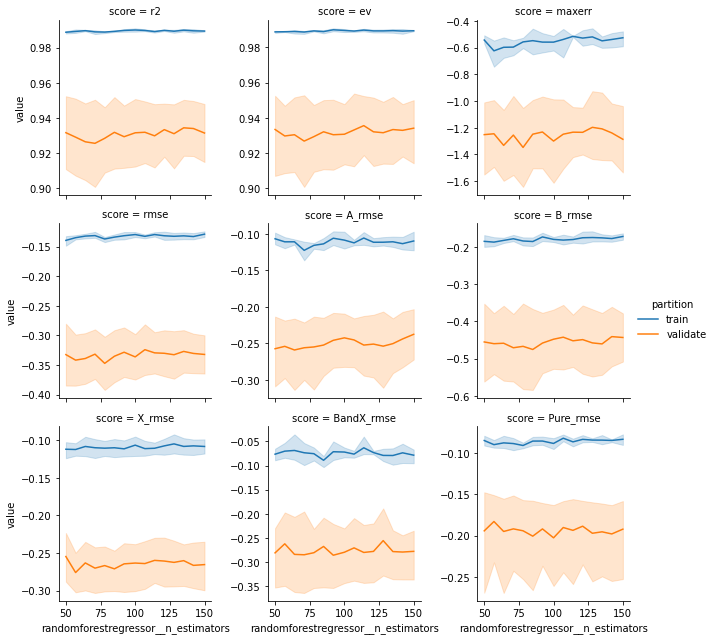

In [20]:
p = sns.FacetGrid(VC, col="score", hue="partition", col_wrap=3, sharey=False)
p.map(sns.lineplot, 'randomforestregressor__n_estimators', "value")
p.add_legend()
p.figure.show()

-   Model scores in this parameter subspace appear to be insensitive to n<sub>estimators</sub>. This is a plesant surprise.
-   maxerror is consistently better between 110 and 120 estimators &#x2013; this is chosen going forward



#### Perform sensitivity analysis for max<sub>leaf</sub><sub>nodes</sub> in optimal subspace



plot a validation curve over max<sub>leaf</sub><sub>nodes</sub> when considering optimal
forest parameters.

If limiting trees on top of an optimal ensemble size improves the
model, good. If not, no loss.



##### Construct subsequent HP space



In [21]:
grid = [
    {'normalizer__norm': ['l1'],
     'randomforestregressor__bootstrap': [True],
     'randomforestregressor__ccp_alpha': [0.0],
     'randomforestregressor__criterion': ['squared_error'],
     'randomforestregressor__max_depth': [20],
     'randomforestregressor__max_features': ['auto'],
     'randomforestregressor__max_leaf_nodes': [700],
     'randomforestregressor__max_samples': [0.9],
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0],
     'randomforestregressor__min_samples_leaf': [1],
     'randomforestregressor__min_samples_split': [2],
     'randomforestregressor__min_weight_fraction_leaf': [0.0],
     'randomforestregressor__n_estimators': [115],
     'randomforestregressor__n_jobs': [4],
     'randomforestregressor__oob_score': [True],
     'randomforestregressor__random_state': [None],
     'randomforestregressor__verbose': [0],
     'randomforestregressor__warm_start': [False]
     }
]

In [22]:
cpipe = cpipe.set_params(**{k:v[0] for k,v in grid[0].items()})

##### max<sub>leaf</sub><sub>nodes</sub> validation scan



using the 4 fold cross validation established by the LC analysis



In [23]:
with joblib.parallel_backend('multiprocessing'):
  VC = pvc(validation_curve, cpipe, mc_tr, my_tr.PBE_bg_eV,
           param_name='randomforestregressor__max_leaf_nodes', param_range=np.linspace(600, 800, 15).astype(int), cv=4, scoring=scorings)
  VC = VC.melt(id_vars=["partition"], ignore_index=False).reset_index()

[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:34 -

[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:35 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:36 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:37 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:38 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-0

[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:39 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:40 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:41 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2

[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:42 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-

[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:43 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INF

[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:38:44 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

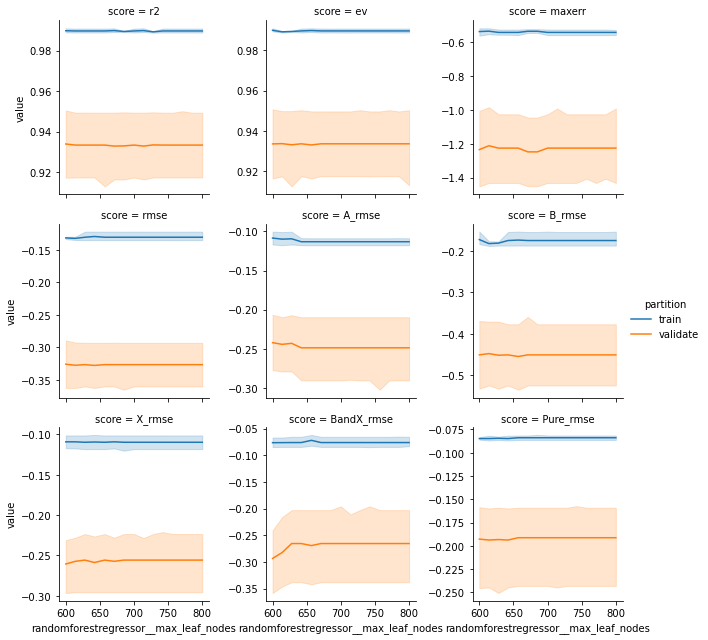

In [24]:
p = sns.FacetGrid(VC, col="score", hue="partition", col_wrap=3, sharey=False)
p.map(sns.lineplot, 'randomforestregressor__max_leaf_nodes', "value")
p.add_legend()
p.figure.show()

-   Model scores in this parameter subspace appear to be mostly insensitive to max<sub>leaf</sub><sub>nodes</sub>.
    -   training scores seem to improve with less restriction
    -   validation scores are mostly flat
    -   validation score variability does tend to increase
    -   to attempt to tighten performance, 650-670 appears best



#### Perform sensitivity analysis for max<sub>depth</sub> in optimal subspace



another possibly sensitive tree parameter, likely of low consequence



##### Construct subsequent HP space



In [1]:
grid = [
    {'normalizer__norm': ['l1'],
     'randomforestregressor__bootstrap': [True],
     'randomforestregressor__ccp_alpha': [0.0],
     'randomforestregressor__criterion': ['squared_error'],
     'randomforestregressor__max_depth': [20],
     'randomforestregressor__max_features': ['auto'],
     'randomforestregressor__max_leaf_nodes': [660],
     'randomforestregressor__max_samples': [0.9],
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0],
     'randomforestregressor__min_samples_leaf': [1],
     'randomforestregressor__min_samples_split': [2],
     'randomforestregressor__min_weight_fraction_leaf': [0.0],
     'randomforestregressor__n_estimators': [115],
     'randomforestregressor__n_jobs': [4],
     'randomforestregressor__oob_score': [True],
     'randomforestregressor__random_state': [None],
     'randomforestregressor__verbose': [0],
     'randomforestregressor__warm_start': [False]
     }
]

In [1]:
cpipe = cpipe.set_params(**{k:v[0] for k,v in grid[0].items()})

##### max<sub>depth</sub> validation scan



using the 4 fold cross validation established by the LC analysis



In [1]:
with joblib.parallel_backend('multiprocessing'):
  VC = pvc(validation_curve, cpipe, mc_tr, my_tr.PBE_bg_eV,
           param_name='randomforestregressor__max_depth', param_range=np.linspace(15, 25, 15).astype(int), cv=4, scoring=scorings)
  VC = VC.melt(id_vars=["partition"], ignore_index=False).reset_index()

In [1]:
p = sns.FacetGrid(VC, col="score", hue="partition", col_wrap=3, sharey=False)
p.map(sns.lineplot, 'randomforestregressor__max_depth', "value")
p.add_legend()
p.figure.show()

-   Model scores in this parameter subspace are again mostly insensitive to max<sub>depth</sub>.
    -   training scores are fine
    -   validation scores are mostly flat
    -   the two are also reasonably close to eachother
    -   validation score variability does tend to increase
    -   to attempt to tighten performance, 20 or 22 appears best



### Best Model



#### Parametrize



In [26]:
grid = [
    {'normalizer__norm': ['l1'],
     'randomforestregressor__bootstrap': [True],
     'randomforestregressor__ccp_alpha': [0.0],
     'randomforestregressor__criterion': ['squared_error'],
     'randomforestregressor__max_depth': [22],
     'randomforestregressor__max_features': ['auto'],
     'randomforestregressor__max_leaf_nodes': [660],
     'randomforestregressor__max_samples': [0.9],
     'randomforestregressor__minBinSize': [1],
     'randomforestregressor__min_impurity_decrease': [0.0],
     'randomforestregressor__min_samples_leaf': [1],
     'randomforestregressor__min_samples_split': [2],
     'randomforestregressor__min_weight_fraction_leaf': [0.0],
     'randomforestregressor__n_estimators': [115],
     'randomforestregressor__n_jobs': [4],
     'randomforestregressor__oob_score': [True],
     'randomforestregressor__random_state': [None],
     'randomforestregressor__verbose': [0],
     'randomforestregressor__warm_start': [False]
     }
]

#### Train Final Estimator



In [27]:
cpipe = cpipe.set_params(**{k:v[0] for k,v in grid[0].items()})
cpipe.fit(mc_tr, my_tr.PBE_bg_eV)

[INFO] 2022-05-03 15:40:06 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=0.0, strategy='constant')),
                ('normalizer', Normalizer(norm='l1')),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=22, max_leaf_nodes=660,
                                       max_samples=0.9, n_estimators=115,
                                       n_jobs=4, oob_score=True))])

#### evaluate



[INFO] 2022-05-03 15:40:09 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


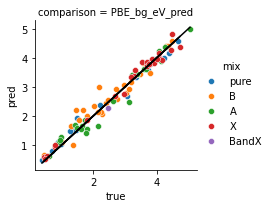

In [28]:
#change between tr and ts suffixes to see test vs train pairity plot
p, data = parityplot(cpipe, mc_ts, my_ts.PBE_bg_eV.to_frame(), aspect=1.0, hue="mix")
p.figure.show()

In [29]:
#optionally save the figure for presentation
p.savefig("./ParityPlots/rfr_bg_c_opt.png", transparent=True)

In [30]:
#change between tr and ts suffixes to see test vs train scores -- both are good
pd.Series(batch_score(cpipe, mc_ts, my_ts.PBE_bg_eV, **scorings)).to_frame()

[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:19 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version

,0
r2,0.966521
ev,0.967716
maxerr,-0.817409
rmse,-0.233442
A_rmse,-0.230446
B_rmse,-0.292486
X_rmse,-0.172478
BandX_rmse,-0.185535
Pure_rmse,-0.200390


The RFR designed here scores consistently well with the test data,
However, parity visual could indicate nonetheless show possible
over fitting to the training data if the spread is not consistent.



### Obtain Generality Measure



In [32]:
test_generality(cpipe, mc_tr, my_tr.PBE_bg_eV, mixcat_tr, mc_ts, my_ts.PBE_bg_eV, mixcat_ts)

[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on 

[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
[INFO] 2022-05-03 15:40:50 - sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


,B,X,A,pure_&_BandX,partition
r2,0.44667,0.93311,0.92462,0.97766,validation
ev,0.60272,0.93547,0.93301,0.97766,validation
maxerr,-1.98907,-1.33223,-2.04886,-0.55668,validation
rmse,-0.71259,-0.34384,-0.38834,-0.21964,validation
BandX_rmse,-0.71259,-0.34384,-0.38834,-0.17253,validation
Pure_rmse,-0.71259,-0.34384,-0.38834,-0.22197,validation
r2,0.75746,0.89585,0.91301,0.97048,test
ev,0.80013,0.89937,0.93449,0.97114,test
maxerr,-1.57226,-1.35690,-0.84370,-0.51048,test
rmse,-0.51043,-0.44079,-0.37376,-0.23705,test


The post-optimization RFR generalizes across all alloy types much
better than the default parameters, but there are clearly limitations.



## Exporting/Importing Trained Model



### save the model for distribution



Never load joblib/pickle files that you do not trust, they can execute
arbitrary code on your computer.



In [33]:
joblib.dump(cpipe, "./Models/rfr_c_opt.joblib")

['./Models/rfr_c_opt.joblib']

### load if needed



In [1]:
cpipe = joblib.load("./Models/rfr_c_opt.joblib")

## Compute Site-Averaged Properties Vectors



In [1]:
mp = mc.ft.derive_from(lookup, "element", "Formula")

## Model BG Using Site-Averaged Properties



### Make Properties Pipeline



In [1]:
ppipe = mkpipe(StandardScaler(), RandomForestRegressor())

## comp+prop model opt

